# Importing required Libraries

In [1]:
from datetime import datetime
import os
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

# Importing Files

In [2]:
pwd

'/Users/ad/Downloads/FYP'

In [3]:
mypath ='/Users/ad/Downloads/FYP/audio_and_txt_files/'
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))]

In [4]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

In [5]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [6]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [7]:
p_diag = pd.read_csv('/Users/ad/Downloads/FYP/patient_diagnosis.csv',header=None) # patient diagnosis file

In [8]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

# Extracting Features

In [9]:
features = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

Finished feature extraction from  920  files


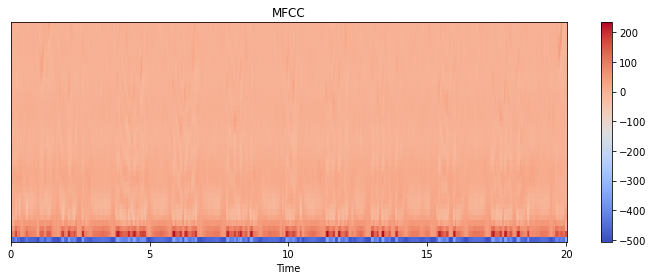

In [10]:
#plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[100], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [11]:
# print class counts
unique_elements, counts_elements = np.unique(labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Asthma' 'Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'LRTI'
  'Pneumonia' 'URTI']
 ['1' '16' '13' '793' '35' '2' '37' '23']]


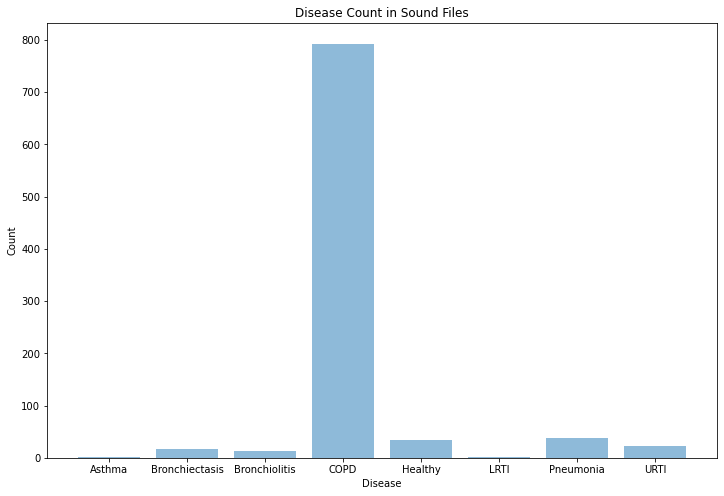

In [12]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

# Remove the data with least cases

In [13]:
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 

labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [15]:
features1.shape

(917, 40, 862)

# Designing Neural Network

In [19]:
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = to_categorical(i_labels)

In [20]:
# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1))

In [21]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

In [22]:
num_rows = 40
num_columns = 862
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [23]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [24]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 861, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 430, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 430, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 429, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 214, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 214, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 213, 64)        8

# Training the model

In [25]:
# train model
num_epochs = 250
num_batch_size = 128

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/250
6/6 [==============================] - 6s 846ms/step - loss: 7.7674 - accuracy: 0.6958 - val_loss: 1.9509 - val_accuracy: 0.8587

Epoch 00001: val_accuracy improved from -inf to 0.85870, saving model to mymodel2_01.h5
Epoch 2/250
6/6 [==============================] - 5s 855ms/step - loss: 3.3561 - accuracy: 0.7135 - val_loss: 1.5433 - val_accuracy: 0.8641

Epoch 00002: val_accuracy improved from 0.85870 to 0.86413, saving model to mymodel2_02.h5
Epoch 3/250
6/6 [==============================] - 5s 869ms/step - loss: 3.0679 - accuracy: 0.8486 - val_loss: 1.1558 - val_accuracy: 0.8533

Epoch 00003: val_accuracy did not improve from 0.86413
Epoch 4/250
6/6 [==============================] - 5s 856ms/step - loss: 1.9866 - accuracy: 0.7967 - val_loss: 1.0494 - val_accuracy: 0.8152

Epoch 00004: val_accuracy did not improve from 0.86413
Epoch 5/250
6/6 [==============================] - 5s 843ms/step - loss: 1.3299 - accuracy: 0.8554 - val_loss: 0.8405 - val_accuracy: 0.8533

E

6/6 [==============================] - 5s 895ms/step - loss: 0.3080 - accuracy: 0.8936 - val_loss: 0.3524 - val_accuracy: 0.8696

Epoch 00042: val_accuracy did not improve from 0.87500
Epoch 43/250
6/6 [==============================] - 5s 841ms/step - loss: 0.2950 - accuracy: 0.8963 - val_loss: 0.3500 - val_accuracy: 0.8641

Epoch 00043: val_accuracy did not improve from 0.87500
Epoch 44/250
6/6 [==============================] - 5s 852ms/step - loss: 0.3282 - accuracy: 0.8840 - val_loss: 0.3528 - val_accuracy: 0.8750

Epoch 00044: val_accuracy did not improve from 0.87500
Epoch 45/250
6/6 [==============================] - 5s 883ms/step - loss: 0.2898 - accuracy: 0.8922 - val_loss: 0.3670 - val_accuracy: 0.8641

Epoch 00045: val_accuracy did not improve from 0.87500
Epoch 46/250
6/6 [==============================] - 5s 877ms/step - loss: 0.2881 - accuracy: 0.9031 - val_loss: 0.3483 - val_accuracy: 0.8641

Epoch 00046: val_accuracy did not improve from 0.87500
Epoch 47/250
6/6 [=====

6/6 [==============================] - 6s 917ms/step - loss: 0.1500 - accuracy: 0.9427 - val_loss: 0.3886 - val_accuracy: 0.8804

Epoch 00124: val_accuracy did not improve from 0.88043
Epoch 125/250
6/6 [==============================] - 5s 881ms/step - loss: 0.1529 - accuracy: 0.9413 - val_loss: 0.4225 - val_accuracy: 0.8750

Epoch 00125: val_accuracy did not improve from 0.88043
Epoch 126/250
6/6 [==============================] - 5s 874ms/step - loss: 0.1575 - accuracy: 0.9427 - val_loss: 0.4750 - val_accuracy: 0.8750

Epoch 00126: val_accuracy did not improve from 0.88043
Epoch 127/250
6/6 [==============================] - 5s 885ms/step - loss: 0.1834 - accuracy: 0.9318 - val_loss: 0.3752 - val_accuracy: 0.8750

Epoch 00127: val_accuracy did not improve from 0.88043
Epoch 128/250
6/6 [==============================] - 5s 884ms/step - loss: 0.1784 - accuracy: 0.9372 - val_loss: 0.3442 - val_accuracy: 0.8804

Epoch 00128: val_accuracy did not improve from 0.88043
Epoch 129/250
6/6 [

6/6 [==============================] - 5s 861ms/step - loss: 0.1575 - accuracy: 0.9427 - val_loss: 0.3188 - val_accuracy: 0.8859

Epoch 00165: val_accuracy did not improve from 0.88587
Epoch 166/250
6/6 [==============================] - 5s 872ms/step - loss: 0.1177 - accuracy: 0.9550 - val_loss: 0.3638 - val_accuracy: 0.8859

Epoch 00166: val_accuracy did not improve from 0.88587
Epoch 167/250
6/6 [==============================] - 5s 858ms/step - loss: 0.1237 - accuracy: 0.9536 - val_loss: 0.4077 - val_accuracy: 0.8750

Epoch 00167: val_accuracy did not improve from 0.88587
Epoch 168/250
6/6 [==============================] - 5s 879ms/step - loss: 0.1324 - accuracy: 0.9495 - val_loss: 0.3459 - val_accuracy: 0.8804

Epoch 00168: val_accuracy did not improve from 0.88587
Epoch 169/250
6/6 [==============================] - 5s 852ms/step - loss: 0.1083 - accuracy: 0.9618 - val_loss: 0.4076 - val_accuracy: 0.8859

Epoch 00169: val_accuracy did not improve from 0.88587
Epoch 170/250
6/6 [

6/6 [==============================] - 5s 838ms/step - loss: 0.0792 - accuracy: 0.9741 - val_loss: 0.4620 - val_accuracy: 0.8750

Epoch 00206: val_accuracy did not improve from 0.89674
Epoch 207/250
6/6 [==============================] - 5s 847ms/step - loss: 0.0899 - accuracy: 0.9700 - val_loss: 0.3802 - val_accuracy: 0.8913

Epoch 00207: val_accuracy did not improve from 0.89674
Epoch 208/250
6/6 [==============================] - 5s 843ms/step - loss: 0.0799 - accuracy: 0.9727 - val_loss: 0.4731 - val_accuracy: 0.8804

Epoch 00208: val_accuracy did not improve from 0.89674
Epoch 209/250
6/6 [==============================] - 5s 833ms/step - loss: 0.0872 - accuracy: 0.9618 - val_loss: 0.3930 - val_accuracy: 0.8913

Epoch 00209: val_accuracy did not improve from 0.89674
Epoch 210/250
6/6 [==============================] - 5s 856ms/step - loss: 0.0827 - accuracy: 0.9673 - val_loss: 0.4747 - val_accuracy: 0.8859

Epoch 00210: val_accuracy did not improve from 0.89674
Epoch 211/250
6/6 [

6/6 [==============================] - 5s 842ms/step - loss: 0.0805 - accuracy: 0.9714 - val_loss: 0.4291 - val_accuracy: 0.8859

Epoch 00247: val_accuracy did not improve from 0.90217
Epoch 248/250
6/6 [==============================] - 5s 929ms/step - loss: 0.0594 - accuracy: 0.9768 - val_loss: 0.4836 - val_accuracy: 0.8913

Epoch 00248: val_accuracy did not improve from 0.90217
Epoch 249/250
6/6 [==============================] - 5s 844ms/step - loss: 0.0634 - accuracy: 0.9754 - val_loss: 0.4423 - val_accuracy: 0.8750

Epoch 00249: val_accuracy did not improve from 0.90217
Epoch 250/250
6/6 [==============================] - 5s 898ms/step - loss: 0.0728 - accuracy: 0.9714 - val_loss: 0.5716 - val_accuracy: 0.8750

Epoch 00250: val_accuracy did not improve from 0.90217
Training completed in time:  0:22:45.755635


In [26]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9263301491737366
Testing Accuracy:  0.875


In [27]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=6 # number of classes

In [28]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [29]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

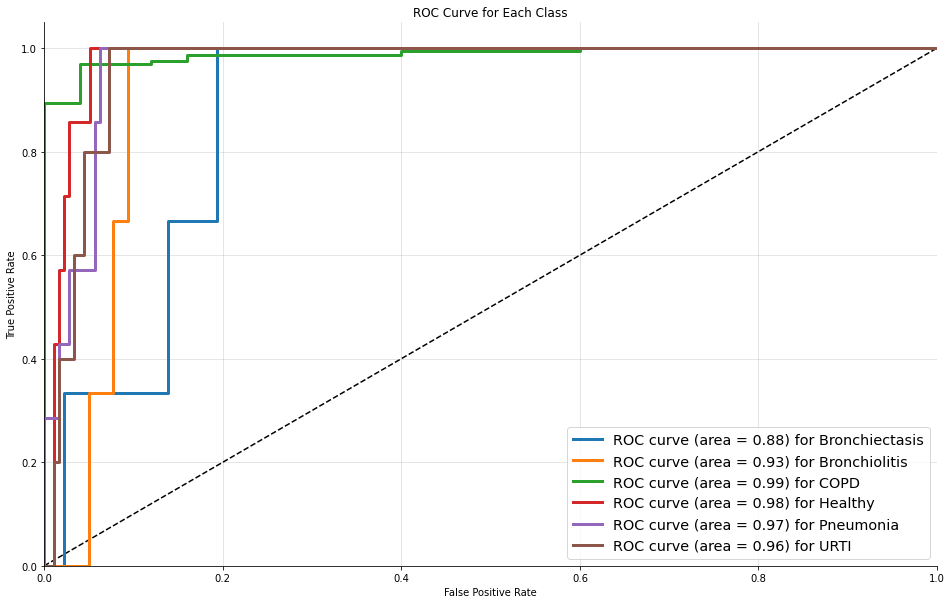

In [30]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [31]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                precision    recall  f1-score   support

Bronchiectasis       0.00      0.00      0.00         3
 Bronchiolitis       0.00      0.00      0.00         3
          COPD       0.90      1.00      0.95       159
       Healthy       0.00      0.00      0.00         7
     Pneumonia       0.40      0.29      0.33         7
          URTI       0.00      0.00      0.00         5

      accuracy                           0.88       184
     macro avg       0.22      0.21      0.21       184
  weighted avg       0.80      0.88      0.83       184



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[  0   0   3   0   0   0]
 [  0   0   3   0   0   0]
 [  0   0 159   0   0   0]
 [  0   0   4   0   1   2]
 [  0   0   5   0   2   0]
 [  0   0   2   1   2   0]]
